In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## CartPole Environment initialization

In [29]:
env1 = gym.make('CartPole-v1')
obs, info = env1.reset()

while True:
    action = env1.action_space.sample()
    obs, reward, terminated, truncated, info = env1.step(action)
    # print(obs)    

    if terminated or truncated:
        break

env1.close()
    

## DQN Algorithm for CartPole Environment

In [30]:
class NeuralNetwork1(nn.Module):

    def __init__(self):
        super(NeuralNetwork1, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)


    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class DQN1():

    def __init__(self, env):

        self.env = env
        self.D = deque([], maxlen=10000)
        self.batch_size = 64

        self.Q_policy = NeuralNetwork1()
        self.Q_prime = NeuralNetwork1()
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.epsilon = 1
        self.epsilon_min = 0.1
        self.gamma = 0.9
        self.rewards = []
        self.epsilon_arr = []

        self.C = 100
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.Q_policy.parameters(), lr=1e-3)

    
    def epsilon_greedy(self, prev_state):

        if self.epsilon > np.random.random():
            action = self.env.action_space.sample()
        else:
            q_values = self.Q_policy(torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0)) 
            action = torch.argmax(q_values).item()
        
        return action
    

    def train_model(self):
        if len(self.D) < 2*self.batch_size:
            return

        batch = random.sample(self.D, self.batch_size)
        
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)
        
        current_q_values = self.Q_policy(states).gather(1, actions)
        
        next_q_values = self.Q_prime(next_states).max(1)[0]
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        target_q_values = target_q_values.unsqueeze(1).detach()

        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()




    
    def train(self):

        for episodes in range(750):

            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(1000):
                
                action = self.epsilon_greedy(prev_state)

                next_state, reward, terminated, truncated, info = self.env.step(action)

                ep_reward+=reward

                done = True if terminated or truncated else False

                self.D.append((prev_state, action, reward, next_state, done))

                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if self.total_steps%self.C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break
            
            self.rewards.append(ep_reward)

            self.epsilon = max(self.epsilon_min, self.epsilon * 0.995)
            self.epsilon_arr.append(self.epsilon)

            

## Dueling DQN Algorithm for CartPole Environment

In [31]:
class DuelingNeuralNetwork1(nn.Module):
    def __init__(self):
        super(DuelingNeuralNetwork1, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)

        # Value stream
        self.value_fc = nn.Linear(64, 1)

        # Advantage stream
        self.advantage_fc = nn.Linear(64, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value_fc(x)

        advantage = self.advantage_fc(x)
        q_values = value + (advantage - advantage.mean())

        return q_values



class DuelingDQN1():

    def __init__(self, env):

        self.env = env
        self.D = deque([], maxlen=10000)
        self.batch_size = 64

        self.Q_policy = DuelingNeuralNetwork1()
        self.Q_prime = DuelingNeuralNetwork1()
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.epsilon = 1
        self.epsilon_min = 0.1
        self.gamma = 0.9
        self.rewards = []
        self.epsilon_arr = []

        self.C = 100
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.Q_policy.parameters(), lr=1e-3)

    
    def epsilon_greedy(self, prev_state):

        if self.epsilon > np.random.random():
            action = self.env.action_space.sample()
        else:
            q_values = self.Q_policy(torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0)) 
            action = torch.argmax(q_values).item()
        
        return action
    

    def train_model(self):
        if len(self.D) < 2*self.batch_size:
            return

        batch = random.sample(self.D, self.batch_size)
        
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)
        
        current_q_values = self.Q_policy(states).gather(1, actions)
        
        next_q_values = self.Q_prime(next_states).max(1)[0]
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        target_q_values = target_q_values.unsqueeze(1).detach()

        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()




    
    def train(self):

        for episodes in range(1000):

            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(500):
                
                action = self.epsilon_greedy(prev_state)

                next_state, reward, terminated, truncated, info = self.env.step(action)

                ep_reward+=reward

                done = True if terminated or truncated else False

                self.D.append((prev_state, action, reward, next_state, done))

                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if self.total_steps%self.C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break
            
            self.rewards.append(ep_reward)

            self.epsilon = max(self.epsilon_min, self.epsilon * 0.995)
            self.epsilon_arr.append(self.epsilon)

            

### CartPole Environment DQN Training

In [32]:
dqn1 = DQN1(env1)
dqn1.train() 

### CartPole Environment Dueling DQN Training

In [33]:
duel_dqn1 = DuelingDQN1(env1)
duel_dqn1.train()

### Saving CartPole model

In [38]:
torch.save(dqn1.Q_policy.state_dict(), 'a2_part_2_dqn_cartpole_christjo_hmanouch.pth')

### Rewards per episode graph

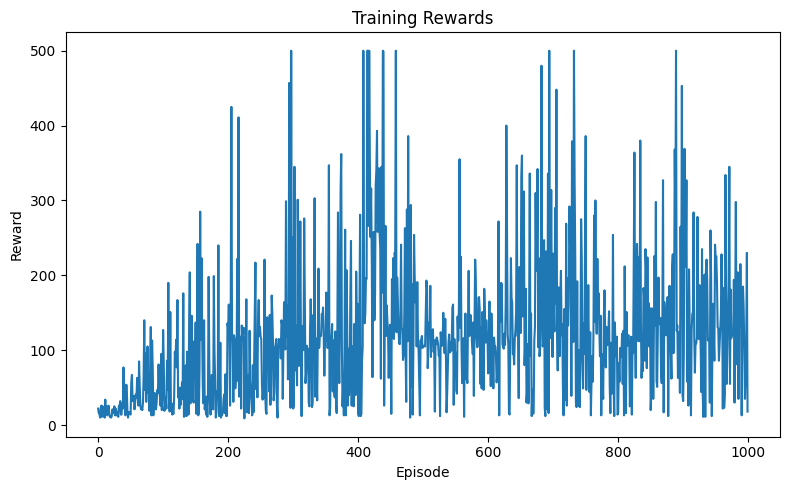

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(duel_dqn1.rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.tight_layout()
plt.show()

### Comparing the Rewards obtained by the two algorithms

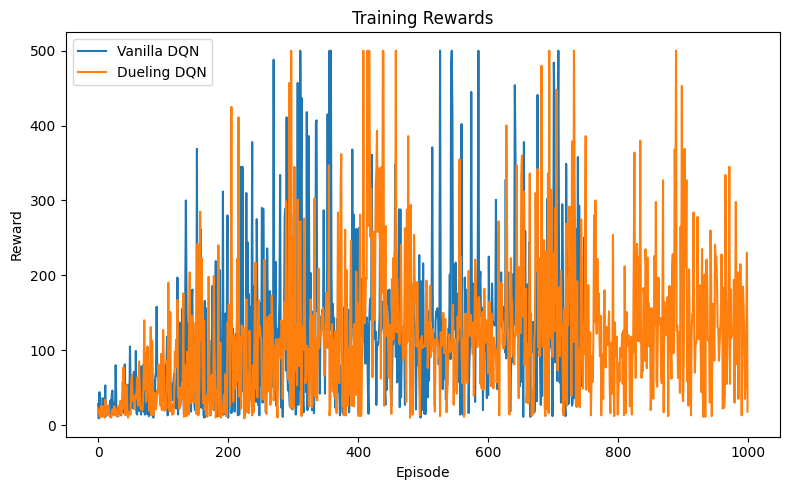

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(dqn1.rewards, label="Vanilla DQN")
plt.plot(duel_dqn1.rewards, label="Dueling DQN")
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

### Epsilon Decay for CartPole Environment

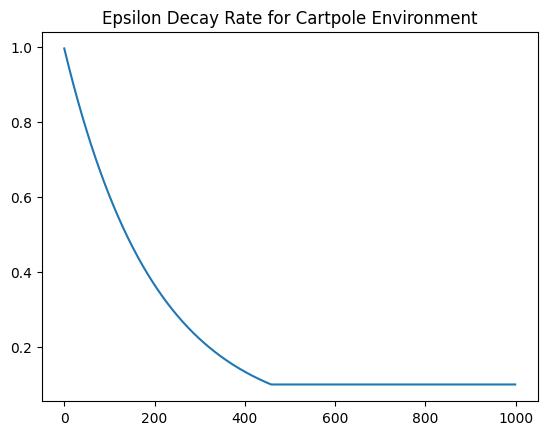

In [29]:
plt.plot(duel_dqn1.epsilon_arr)
plt.title('Epsilon Decay Rate for Cartpole Environment')
plt.show()

## Testing the agent with greedy actions for 5 episodes

In [41]:
cart = gym.make('CartPole-v1', render_mode='human')
total_reward_cart = []
for _ in range(5):
    obs, _ = cart.reset()
    total_reward = 0
    
    for _ in range(100):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            action = torch.argmax(duel_dqn1.Q_policy(obs_tensor)).item()
        
        obs, reward, terminated, truncated, _ = cart.step(action)
        total_reward += reward
        
        # frame = env.render()

        if terminated or truncated:
            break
    
    total_reward_cart.append(total_reward)

cart.close()

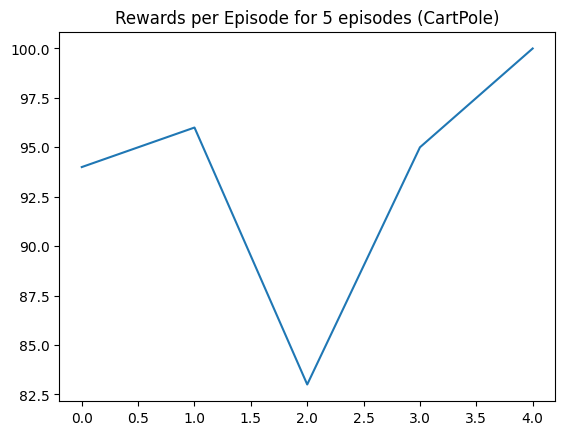

In [40]:
plt.plot(total_reward_cart)
plt.title('Rewards per Episode for 5 episodes (CartPole)')
plt.show()

## LunarLander Environment Initialization

In [2]:
env2 = gym.make('LunarLander-v3')
obs, info = env2.reset()

while True:
    action = env2.action_space.sample()
    obs, reward, terminated, truncated, info = env2.step(action)

    if terminated or truncated:
        break

    # print(f'Reward: {reward}\n Obs: {obs}\n\n')

env2.close()


### DQN Algorithm for LunarLander environment

In [19]:
class NeuralNetwork2(nn.Module):

    def __init__(self):
        super(NeuralNetwork2, self).__init__()

        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)


    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class DQN2():

    def __init__(self, env):

        self.env = env
        self.D = deque([], maxlen=50000)
        self.batch_size = 128

        self.Q_policy = NeuralNetwork2()
        self.Q_prime = NeuralNetwork2()
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.epsilon = 1
        self.epsilon_min = 0.1
        self.gamma = 0.8
        self.rewards = []
        self.epsilon_arr= []

        self.C = 100
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.Q_policy.parameters(), lr=1e-2)

    
    def epsilon_greedy(self, prev_state):

        if self.epsilon > np.random.random():
            action = self.env.action_space.sample()
        else:
            q_values = self.Q_policy(torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0)) 
            action = torch.argmax(q_values).item()
        
        return action
    

    def train_model(self):
        if len(self.D) < 3*self.batch_size:
            return

        batch = random.sample(self.D, self.batch_size)
        
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)
        
        current_q_values = self.Q_policy(states).gather(1, actions)
        
        next_q_values = self.Q_prime(next_states).max(1)[0]
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones) 
        target_q_values = target_q_values.unsqueeze(1).detach()
        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()




    
    def train(self):

        for episodes in range(750):

            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(100):
                
                action = self.epsilon_greedy(prev_state)

                next_state, reward, terminated, truncated, info = self.env.step(action)

                ep_reward+=reward

                done = True if terminated or truncated else False

                self.D.append((prev_state, action, reward, next_state, done))

                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if t%self.C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break
            
            self.rewards.append(ep_reward)

            self.epsilon = max(self.epsilon_min, self.epsilon * 0.995)
            self.epsilon_arr.append(self.epsilon)

            

## Dueling DQN Algorithm for LunarLander Environment

In [20]:
class DuelingNeuralNetwork2(nn.Module):
    def __init__(self):
        super(DuelingNeuralNetwork2, self).__init__()

        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)

        # Value stream
        self.value_fc = nn.Linear(64, 1)

        # Advantage stream
        self.advantage_fc = nn.Linear(64, 4)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value_fc(x)

        advantage = self.advantage_fc(x)
        q_values = value + (advantage - advantage.mean())

        return q_values



class DuelingDQN2():

    def __init__(self, env):

        self.env = env
        self.D = deque([], maxlen=10000)
        self.batch_size = 64

        self.Q_policy = DuelingNeuralNetwork2()
        self.Q_prime = DuelingNeuralNetwork2()
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.epsilon = 1
        self.epsilon_min = 0.1
        self.gamma = 0.9
        self.rewards = []
        self.epsilon_arr = []

        self.C = 100
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.Q_policy.parameters(), lr=1e-3)

    
    def epsilon_greedy(self, prev_state):

        if self.epsilon > np.random.random():
            action = self.env.action_space.sample()
        else:
            q_values = self.Q_policy(torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0)) 
            action = torch.argmax(q_values).item()
        
        return action
    

    def train_model(self):
        if len(self.D) < 2*self.batch_size:
            return

        batch = random.sample(self.D, self.batch_size)
        
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)
        
        current_q_values = self.Q_policy(states).gather(1, actions)
        
        next_q_values = self.Q_prime(next_states).max(1)[0]
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        target_q_values = target_q_values.unsqueeze(1).detach()

        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()




    
    def train(self):

        for episodes in range(750):

            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(100):
                
                action = self.epsilon_greedy(prev_state)

                next_state, reward, terminated, truncated, info = self.env.step(action)

                ep_reward+=reward

                done = True if terminated or truncated else False

                self.D.append((prev_state, action, reward, next_state, done))

                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if self.total_steps%self.C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break
            
            self.rewards.append(ep_reward)

            self.epsilon = max(self.epsilon_min, self.epsilon * 0.995)
            self.epsilon_arr.append(self.epsilon)

            

### Training LunarLander model using DQN

In [21]:
dqn2 = DQN2(env2)
dqn2.train()

### Training LunarLander model using Dueling DQN

In [22]:
duel_dqn2 = DuelingDQN2(env2)
duel_dqn2.train()

### Saving LunarLander model

In [28]:
torch.save(duel_dqn2.Q_policy.state_dict(), 'a2_part_3_lunarlander_christjo_hmanouch.pth')

### Rewards per Episode graph for LunarLander Environment

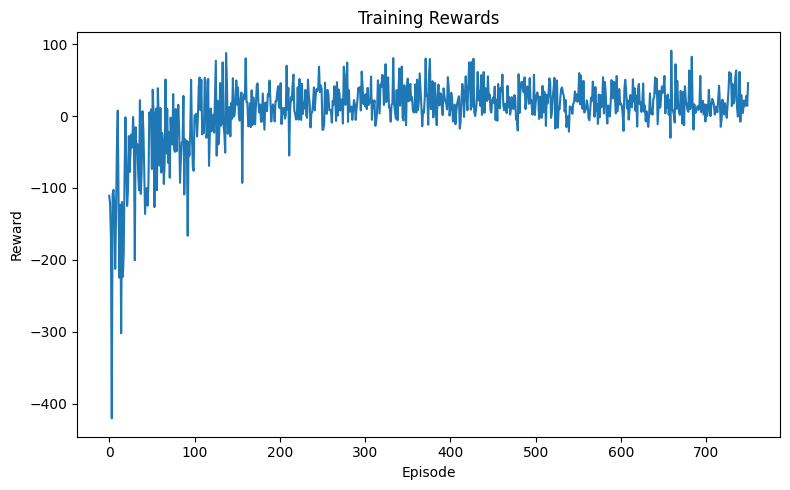

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(duel_dqn2.rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.tight_layout()
plt.show()

### Comparing the rewards obtained by the two algorithms

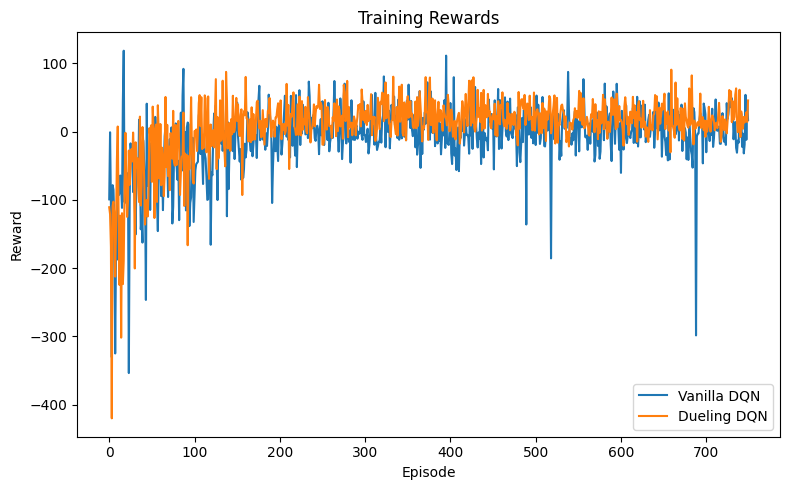

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(dqn2.rewards, label="Vanilla DQN")
plt.plot(duel_dqn2.rewards, label="Dueling DQN")
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

### Epsilon Decay for LunarLander Environment

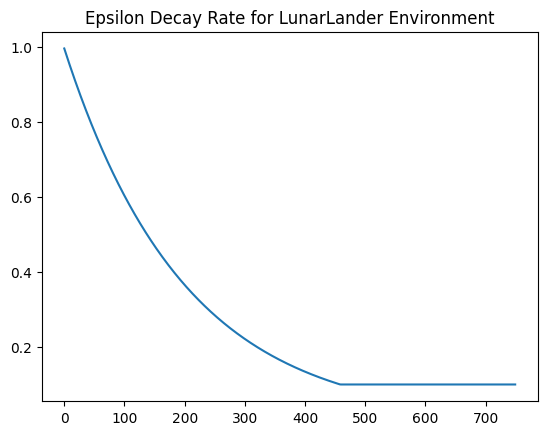

In [42]:
plt.plot(dqn2.epsilon_arr)
plt.title('Epsilon Decay Rate for LunarLander Environment')
plt.show()

## Testing the agent with greedy actions for 5 episodes

In [42]:

lunar = gym.make('LunarLander-v3', render_mode='human')
total_reward_lunar = []

for _ in range(5):
    obs, _ = lunar.reset()
    total_reward = 0

    for _ in range(1000):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            action = torch.argmax(duel_dqn2.Q_policy(obs_tensor)).item()
        
        obs, reward, terminated, truncated, _ = lunar.step(action)
        total_reward += reward

        if terminated or truncated:
            break
    
    total_reward_lunar.append(total_reward)

lunar.close()

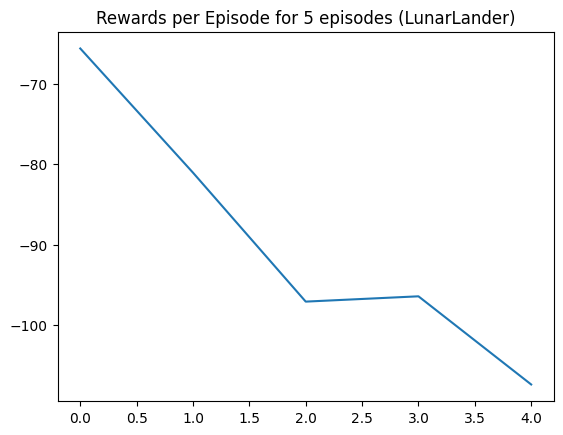

In [43]:
plt.plot(total_reward_lunar)
plt.title('Rewards per Episode for 5 episodes (LunarLander)')
plt.show()